# STEP 1: Pre-processing

## Import necessary packages

In [1]:
import os

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # Python has packages for specific domains: torchvision, torchaudio, torchtext. These include datasets among others.
from torchvision.transforms import ToTensor

## Data transformation and retrieval

Here we will use the MNIST dataset, which we can load using a dedicated PyTorch module 'Dataset'.
The Dataset module includes many built in datasets (full list: https://pytorch.org/vision/stable/datasets.html), but also supports custom datasets.
Upon calling this module we will specify data transformations we want to apply.

In [3]:
# Define a series of transformations to apply to the input images
transformations = transforms.Compose([
    # Transform a grayscale image to RGB. MNIST is originally in grayscale (1 channel with value range: 0-255)
    transforms.Grayscale(num_output_channels=3),
    # Resize the image to 256x256 pixels. This ensures that all input images have a uniform size.
    transforms.Resize(256), 
    # Center crop the image to 224x224 pixels. This removes any borders and focuses on the central part of the image.
    transforms.CenterCrop(224),
    # Convert the image to a PyTorch tensor. This also effectively changes the value range from 0-255 to 0-1. 
    transforms.ToTensor(),
    # Optionally, we will feed our dataset to a pretrained AlexNet (https://pytorch.org/hub/pytorch_vision_alexnet/). 
    # This model requires the images to be normalized using these values.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We then download the data using the specified transformations
download_path = os.path.join("data") # Specify location to store MNIST data. This is an OS-friendly way of specifying the path. Change as desired.
# Create the folder if doesn't exist.
if not os.path.exists(download_path):
    os.makedirs(download_path)

train_data = datasets.MNIST(download_path, train=True, download=True, transform=transformations) # Create a dataset for training
test_data = datasets.MNIST(download_path, train=False, download=True, transform=transformations) # Create a dataset for testing (train=False!)

## PyTorch DataLoader
PyTorch has another module called DataLoader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
This module helps with sampling and iterating over the Dataset object created earlier. This also helps with sampling batches of images during training, instead of feeding single images.
Additionally, it uses Python's multiprocessing functionality to sample data faster.

In [5]:
# Specify the batch size
batch_size = 64

# Create dataloaders for the training and test datasets respectively
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

The DataLoader is a generator, meaning that it does not store its contents in memory (as with a Python list).
In order to access its contents we need to loop over it, or alternatively call a batch with next(iter(DataLoader object))

In [7]:
# Printing the dataloader object directly won't show its contents. Instead you see where the object itself is stored in memory.
print(train_loader)

In [8]:
# Let's have a look at what it yields.
sample = next(iter(train_loader))
sample

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

The Dataloader returns both the image data, and the corresponding labels.
Let's split these up and take a closer look at the structure of these variables.

In [10]:
sample_images, sample_labels = next(iter(train_loader))
print(f"Sample_data shape: {sample_images.shape}")
print(f"Sample_labels shape: {sample_labels.shape}")

Sample_data shape: torch.Size([64, 3, 224, 224])
Sample_labels shape: torch.Size([64])


As you can see, both variables are batches of 50. The image additionally has 3 channels (RGB), each with a size of 224 by 224 pixels.
Looking at 'sample_labels', we can see it contains the true digit labels of the corresponding images.

In [18]:
sample_labels

tensor([2, 7, 3, 0, 3, 7, 1, 9, 9, 6, 3, 8, 2, 9, 9, 2, 1, 5, 6, 6, 4, 3, 1, 6,
        2, 4, 6, 6, 1, 5, 4, 9, 2, 8, 6, 0, 8, 9, 5, 8, 6, 5, 8, 0, 6, 0, 3, 1,
        0, 1, 7, 7, 8, 9, 7, 9, 5, 6, 1, 4, 1, 8, 8, 7])

Let's check the first image as an example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


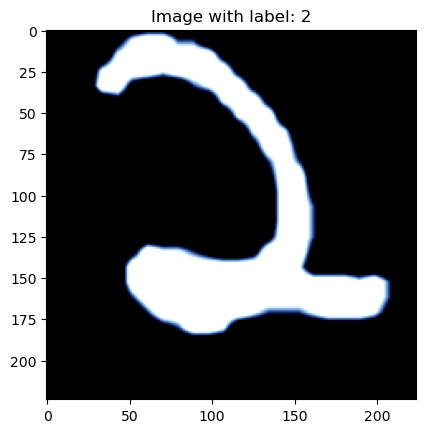

In [21]:
im_id = 0

plt.imshow(sample_images[im_id].permute((1,2,0)))
plt.title(f"Image with label: {sample_labels[im_id]}")
plt.show()

# STEP 2: Create the model

## Check Device for Training
Depending on your system, you can choose whether to train the model on your CPU (Central Processing Unit) or GPU (Graphical Processing Unit).
Choosing to run the training process on your GPU will significantly increase the training speed. In PyTorch you can set the device to 'cuda' (Compute Unified Device Architecture), which is a sort of software interface that allows for general purpose computing on certain types of GPUs.

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Configures to cuda if it is available.
print(f"Using {device} device")

Using cpu device


## The Model Architecture
Firstly, we need to define the model architecture. In other words, we need to define the amount and types of layers, in which order they are arranged, and how many inputs and outputs there are for each layer. Additionally, we define the activation functions that make the model non-linear. All this information is organized by means of a Python class. The model architecture will thus be contained within an object. 

TODO: We can either choose to highlight the different types of layers one-by-one here, or choose to explain the model line by line (less appropiate for self-study), or highlight the different layers after introducing the full model.

We can put simple schematic pictures here to aid understanding

- Flatten: transforms a 2d input to one dimension (see example below)
- Linear: fully connected layer
- ReLu: activation function to introduce non-linearity into the network, applies max(0,x)
(nog meer uitleggen ook wat die init, en super is enzo)

In [29]:
#create model structure
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Example of how the Flatten function works

In [32]:
sample_image, sample_label = next(iter(test_loader))
sample_image.to(device)
flatten = nn.Flatten()
output = flatten(sample_image)
output.size()

torch.Size([64, 150528])

To classify images (especially more naturalistic once) you might want to add convolutional layers to increase the performance of the model. 
Here you see the architecture of a simple model with one convolutional layer. 

If there is time left, we will come back to this and explain how it works. Otherwise, you can read through this explanation yourself if you are interested.

...

(maybe we can add a link here as well to the video of 3b1b explaining convolution?)



In [35]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 10 , kernel_size = 3, stride = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
            )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10*110*110, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

Choose which model you want to use:

In [38]:
model = SimpleNeuralNetwork()
#model = ConvNeuralNetwork()
print(model)

SimpleNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Step 3: Prepare the training and testing of the model
## Define function to train the model
First we will define a function to train the model. This functions takes as input: 
- the dataloader: in this case that will be the dataloader with the training data
- the model architecture
- the loss function, which computes the dissimilarity between the network's predictions (pred) and the actual answer (y)
- the optimizer functions, which computes the gradient based on the losses (dit moet anders verwoord zijn denk ik)
- the current epoch to track the network's performance

We set the model to training mode (model.train), this is important if you want to include batch normalization and dropout layers. Which we don't use here, but we include it for best practices.

For each batch in the dataloader:
1. we pass the input (X) through the model.
2. The loss function calculates the dissimilarities between the prediction and the actual answer (y).
3. the gradients of the losses are computed by taking the derivatives of the loss functions for each parameter (loss.backward).
4. The optimizer than adjusts the parameters with these gradients (optimizer_step)
5. the gradients are set back to zero to prevent the gradients to keep adding up across batches (optimizer.zero_grad).
6. for each 10 and 100 batches we track the losses/progress of the training


In [41]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #track the losses for visualization
        if batch % 10 == 0:
            train_losses.append(loss.item())
            train_counter.append((batch*64) + (epoch*len(dataloader.dataset)))

        #track progress of the training
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



## Define function to test the model:
Next we define a function to test the model. This function takes as input: 
- the dataloader: in this case that will be the dataloader with the test data
- the model architecture
- the loss function
(we don't need the optimizer function, since we won't update the parameters anymore.)

We set the model to evaluation mode (model.eval), this is important if you want to include batch normalization and dropout layers. Which we don't use here, but we include it for best practices.

We initiate two empty variables to keep track of the model's performance

We evaluate the model with torch.no_grad() to ensure that no gradients are computed during test mode (this also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True).

We store the losses and correct answers to compute the accuracy and average loss of the model.


In [44]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# Step 5: Train the model

## Defining the hyperparameters
Start by defining the hyperparameters:
- epochs: the number of epochs = number of times that the training dataset is passed through the model
- learning rate: value indicating to which extent the model parameters are updated for each batch/epoch (smaller values lead to slower updating).
- loss function: PyTorch has different build in functions to calculate the losses
- optimizer function: PyTorch has different build in functions for optimization

Here we will use CrossEntropyLoss as the loss function. This function applies a softmax transformation to the models output to obtain the predicted class probabilities. Afterwards it computes the negative log-likelihood loss between the predicted probabilities and the true labels.

For the optimizer we use stochastic gradient descent. (leggen we dat hier nog verder uit?)

Next we will initiate a couple of empty lists to keep track of the network's performance

## Test the untrained model
First we test the untrained model, which performance do you expect?

## Now everything is ready to train and test the network! 
We use a for loop to repeat the process for n epochs using the functions we created previously.
After each training loop, we use the test loop to check the performance of the model.
Note that the model thus also sees the test data for several times. 
To have a true evaluation of the model, you would actually need data that the model has never seen before (you could do this by splitting the data in the beginning when you are downloading it and creating the dataloaders).


In [47]:
#define hyperparameters
epochs = 1
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss() #this step applies the softmax transformation and can compare the output of the model with integers
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

#test the untrained model
test_loop(test_loader, model, loss_fn)

#train the model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, t)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Test Error: 
 Accuracy: 14.8%, Avg loss: 2.299349 

Epoch 1
-------------------------------
loss: 2.310870  [   64/60000]
loss: 0.518241  [ 6464/60000]
loss: 0.431431  [12864/60000]
loss: 0.189064  [19264/60000]
loss: 0.314209  [25664/60000]
loss: 0.411204  [32064/60000]
loss: 0.158989  [38464/60000]
loss: 0.177559  [44864/60000]
loss: 0.592501  [51264/60000]
loss: 0.207847  [57664/60000]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.244077 

Done!


## Visualize the model's progress
Now we can create a graph to see how the losses of the model go down.

Text(0, 0.5, 'negative log likelihood loss')

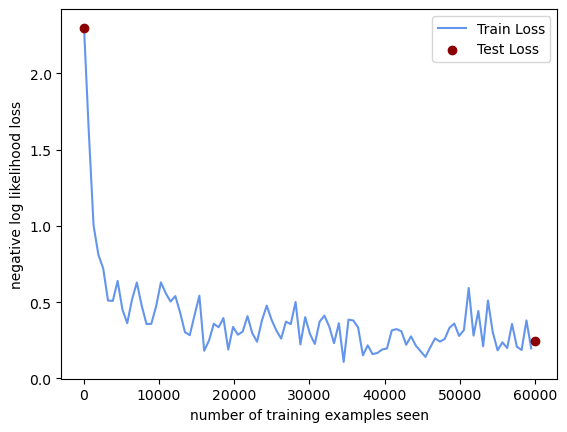

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='cornflowerblue', linewidth=1.5)
plt.scatter(test_counter, test_losses, zorder = 5, color='darkred')         
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

# Save the model

Lastly, you can store the network in different ways, depending on whether you only want to save its architecture or also the trained weights and biases.

In [ ]:
#save  model
torch.save(model, 'modelMNIST.pth')

#if you would want to load the model again
model = torch.load('modelMNIST.pth', weights_only=False), 
